# Data Science Project - NYC Uber and Taxi Data
## Final report
## Team Members:
### Dhruv Anand (danand), Abhik Mondal (abhikm)

The objective of this project is to try and glean interesting observations by combining information from various publicly available geographical datasets relating to NYC. Information from different datasets will be combined to answer interesting questions about the behavior of people in New York.

We will mainly deal with the following datasets:
1. [Uber Trips](https://github.com/fivethirtyeight/uber-tlc-foil-response/tree/master/uber-trip-data) (pickup coordinate and time data)
2. [Taxi Trips](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) (pickup and drop coordinates and times)
3. [Subways station locations](https://data.ny.gov/Transportation/MTA/mcgj-dt7q)
4. [Foursquare check-in data](https://sites.google.com/site/yangdingqi/home/foursquare-dataset)

## Contents

* [Data Loading](#Loading-Data)
* [Data Cleaning](#Data-Cleaning)
* [Raw Data Visualization](#Visualizing-raw-data)
* [Initial Question](#Initial-Question)
* [Temporal Analysis](#Temporal-Analysis)


In [2]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Polygon,Point
from geopy.geocoders import GoogleV3
import rtree
import datetime
import numpy as np
import re
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Loading Data

In [3]:
# Shapes of NYC boroughs
boros = gpd.GeoDataFrame.from_file('nybb_16d/nybb.shp').to_crs({'init': 'epsg:4326'})

# Zipcode shapes might be needed
zips = gpd.GeoDataFrame.from_file('ZIP_CODE_040114/ZIP_CODE_040114.shp').to_crs({'init': 'epsg:4326'})

non_decimal = re.compile(r'[^\s\d.-]+')
subways = pd.read_csv('DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv')
# Converting strings of coordinates to shapely point objects
subways['geometry'] = subways['the_geom'].apply(lambda z: Point(map(float,non_decimal.sub('', z).strip().split(' '))))
subways = gpd.GeoDataFrame(subways)

# Data Cleaning

The Taxi dataset we are looking was released by the NYC Taxi and Limousine Commission 2013 . 
The dataset contains the following fields:

```medallion, hack_license, vendor_id, rate_code, store_and_fwd_flag, pickup_datetime, dropoff_datetime, passenger_count, trip_time_in_secs, trip_distance, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude.```

Since we only deal with pickup positions (at this point), we can remove all the other columns. Since the dataset is quite large, we also need to randomly sample a smaller set for our purposes. We do this by shuffling the csv file and taking only the top `lim` rows.


```bash
cut -d, -f6-7 yellow_tripdata_2011-02.csv  > taxi_before.csv
tail -n +2 taxi_before.csv
gshuf -n 10000 taxi_before_w.csv > taxi_before_final.csv
echo 'pickup_longitude,pickup_latitude' | cat - taxi_before_final.csv > tmp && mv tmp taxi_before_final.csv
```


## Pipeline
We define a function that:
1. takes in a csv file with a list of coordinates,
2. converts it into a GeoPandas DataFrame, while
3. dealing with different coordinate systems,
4. making sure all points lie within the boundaries of NYC and,
5. removing invalid points with `0` values.

In [121]:
def keep_manhattan(df):
    plist = [(40.699269, -74.020504),(40.700270, -74.003787),(40.707273, -73.992790),(40.709941, -73.972554),(40.750907, -73.963284),(40.776551, -73.939763),(40.789735, -73.934663),(40.798923, -73.927452),(40.809041, -73.932904),(40.833131, -73.934135),(40.851093, -73.924814),(40.871710, -73.909161),(40.881950, -73.930090),(40.754897, -74.012863),(40.715025, -74.028353)]
    ny_simple = Polygon(map (lambda t: (t[1], t[0]), plist))
    return df[df.apply(lambda x: ny_simple.contains(x.geometry), axis=1)]
def create_dataframe(fn,Lon,Lat,lim=1000000,names=None,delim=None,disableSJ = False):
    if names is None:
        df = pd.read_csv(fn,nrows=lim,delimiter=delim)
    else:
        df = pd.read_csv(fn,nrows=lim, names=names, header=None,delimiter=delim)
    df = df[df[Lon]!=0.0]
    df['geometry'] = [Point(xy) for xy in zip(df[Lon], df[Lat])]
    df = gpd.GeoDataFrame(df)
    if df.crs is None:
        df.crs = {'init':'epsg:4326'}
    if not disableSJ:
        df = keep_manhattan(df)
    return df

In [110]:
# Retrieving 2000 so that removal of pickups outside NYC don't make the total number fall below 1000
uber = create_dataframe('uber-tlc-foil-response-master/uber-trip-data/uber-raw-data-apr14.csv','Lon','Lat',lim=200000)
taxi = create_dataframe('taxi.csv','pickup_longitude','pickup_latitude',lim=200000)

print uber.head()
print taxi.head()

Index([u'Date/Time', u'Lat', u'Lon', u'Base', u'geometry'], dtype='object')
Index([u'pickup_longitude', u'pickup_latitude', u'geometry'], dtype='object')
          Date/Time      Lat      Lon    Base  \
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512   
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512   
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512   
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512   
6  4/1/2014 0:39:00  40.7223 -73.9887  B02512   

                             geometry  
0   POINT (-73.95489999999999 40.769)  
2            POINT (-73.9873 40.7316)  
3            POINT (-73.9776 40.7588)  
4            POINT (-73.9722 40.7594)  
6  POINT (-73.98869999999999 40.7223)  
   pickup_longitude  pickup_latitude                              geometry
0        -73.978165        40.757977          POINT (-73.978165 40.757977)
1        -74.006683        40.731781          POINT (-74.006683 40.731781)
2        -74.004707        40.737770           POINT (-74.004707 40.73777)
3        -7

In [11]:
fSqCheckins = create_dataframe('dataset_TSMC2014_NYC.txt','Lon','Lat',
                               names=['UID','VID','catID','catname','Lat','Lon','Timezone offset','UTC time']
                               ,delim='\t',disableSJ=True)
print fSqCheckins.head()

   UID                       VID                     catID  \
0  470  49bbd6c0f964a520f4531fe3  4bf58dd8d48988d127951735   
1  979  4a43c0aef964a520c6a61fe3  4bf58dd8d48988d1df941735   
2   69  4c5cc7b485a1e21e00d35711  4bf58dd8d48988d103941735   
3  395  4bc7086715a7ef3bef9878da  4bf58dd8d48988d104941735   
4   87  4cf2c5321d18a143951b5cec  4bf58dd8d48988d1cb941735   

               catname        Lat        Lon  Timezone offset  \
0  Arts & Crafts Store  40.719810 -74.002581             -240   
1               Bridge  40.606800 -74.044170             -240   
2       Home (private)  40.716162 -73.883070             -240   
3       Medical Center  40.745164 -73.982519             -240   
4           Food Truck  40.740104 -73.989658             -240   

                         UTC time  \
0  Tue Apr 03 18:00:09 +0000 2012   
1  Tue Apr 03 18:00:25 +0000 2012   
2  Tue Apr 03 18:02:24 +0000 2012   
3  Tue Apr 03 18:02:41 +0000 2012   
4  Tue Apr 03 18:03:00 +0000 2012   

             

In [ ]:
print taxi['BoroName'].value_counts()
print uber['BoroName'].value_counts()

# Visualizing raw data

## Ubers and Taxis

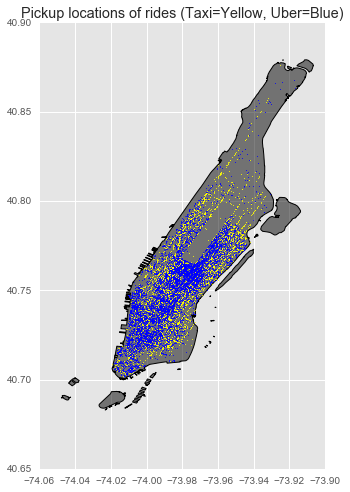

In [112]:
# Plots of scatter plot of taxi/uber in NYC
base = boros[boros['BoroName']=='Manhattan'].plot(figsize=(8,8))
plt.title('Pickup locations of rides (Taxi=Yellow, Uber=Blue)')
taxi[:10000].plot(ax=base, color='yellow',markersize=1);
uber[:10000].plot(ax=base, color='blue',markersize=1);

## Foursquare Check-ins

We carry out a spatial join with the polygon describing Manhattan before plotting.

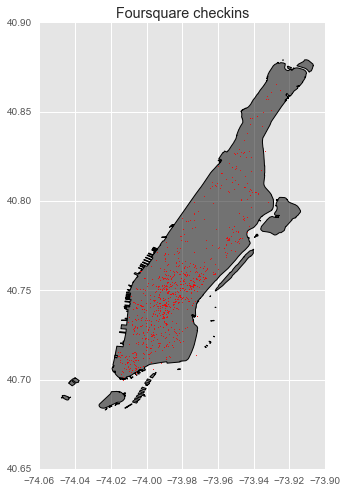

In [114]:
base = boros[boros['BoroName']=='Manhattan'].plot(figsize=(8,8))
manhattan_checkins = keep_manhattan(fSqCheckins[:10000])
plt.title('Foursquare checkins')
manhattan_checkins[:1000].plot(ax=base,color='red',markersize=1);

## Subways

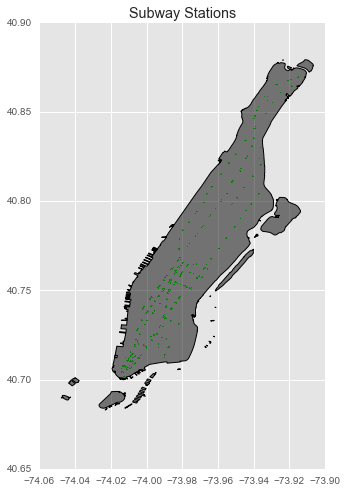

In [115]:
base = boros[boros['BoroName']=='Manhattan'].plot(figsize=(8,8))
plt.title('Subway Stations')
subways.crs = {'init':'epsg:4326'}
manhattan_subways = keep_manhattan(subways)
manhattan_subways.plot(ax=base, color='green',markersize=1);

We removed non-Manhattan points from other datasets as rides are mainly concentrated in the Manhattan region.

In [116]:
#Plot
def getx(pt):
    return pt.coords[0][0]

def gety(pt):
    return pt.coords[0][1]

from scipy import ndimage
def get_heatmap(x, y,range_2d,bins=100):
    xr= np.linspace(range_2d[0][0],range_2d[0][1],bins,dtype=float)
    yr = np.linspace(range_2d[1][0],range_2d[1][1],bins,dtype=float)
    heatmap, xedges, yedges = np.histogram2d(y, x,bins=(xr,yr))
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    return heatmap,extent
    
def draw_heatmap(x,y,bins,smoothing=1.3, cmap='jet'):
    range_2d=[[min(y),max(y)],[min(x),max(x)]]
    heatmap,extent = get_heatmap(x,y,range_2d,bins)
    draw_heatmap_diff(heatmap,extent,smoothing, cmap)
    return heatmap
    
def draw_heatmap_diff(heatmap,extent,smoothing=0, cmap='jet'):
    with np.errstate(divide='ignore', invalid='ignore'):
        logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    
def draw_diff(df1,df2,bins,smoothing=1.3, cmap='jet'):
    x1,y1 = get_xy(df1)
    x2,y2 = get_xy(df2)
    range_2d = [[min(min(y1),min(y2)),max(max(y1),max(y2))],[min(min(x1),min(x2)),max(max(x1),max(x2))]]
    h1,e1 =get_heatmap(x1, y1,range_2d, bins)
    h2,e2 =get_heatmap(x2, y2,range_2d, bins)
    h_net = h1-h2
    h_net[h_net<0]=0
    draw_heatmap_diff(h_net,e1,cmap=cmap)
    return h_net, np.linalg.norm(h_net,1)#/(h_net.size)
    
def get_xy(df):
    return (list(df.geometry.apply(getx)),list(df.geometry.apply(gety)))


# Initial Question

We want to first determine whether the launch of Uber affected the business of Taxis in the first 9 months.

# Visualizing differences in Taxi and Uber usage

We partition the points into rectangular bins and draw heat-maps of the differences in the histograms we obtain from these bins to give us an idea of the area where one service outperforms the other.

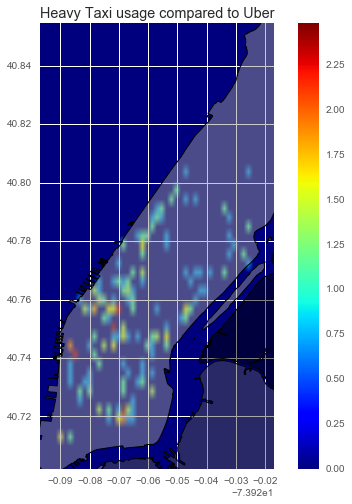

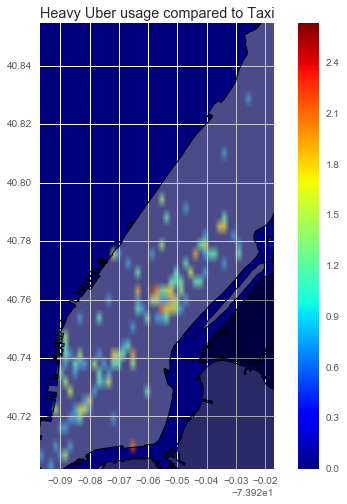

In [117]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
boros.plot(ax=ax)
plt.title('Heavy Taxi usage compared to Uber')
h_net,norm =draw_diff(taxi[:1000],uber[:1000],50,cmap='jet')
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
boros.plot(ax=ax)
plt.title('Heavy Uber usage compared to Taxi')
h_net,norm =draw_diff(uber[:1000],taxi[:1000],50,cmap='jet')


# Visualizing differences in usage of Taxis before and after launch of Uber

Uber was launched in NYC in **May 2011**. Since the data for Uber is not available for the time period immediately after its launch, we can use the taxi data for that time to analyze the impact of Uber on taxi demand. We have compared data from **Feb 2011** to **Feb 2012** to eliminate any seasonal effects and to account for the time it took for Uber usage to grow after its launch.

In [120]:
taxi_before = create_dataframe('taxi_before_final.csv','pickup_longitude','pickup_latitude',lim=5000)
taxi_after = create_dataframe('taxi_after_final.csv','pickup_longitude','pickup_latitude',lim=5000)

Index([u'pickup_longitude', u'pickup_latitude', u'geometry'], dtype='object')
Index([u'pickup_longitude', u'pickup_latitude', u'geometry'], dtype='object')


In [122]:
print len(taxi_before),len(taxi_after)
# Keeping number of points in both data frames the same.
taxi_before = taxi_before[:4000]
taxi_after = taxi_after[:4000]

4496 4539


The decrease in trips in bins where the taxi usage decreased:  55.0
The increase in trips in bins where the taxi usage increased:  46.0


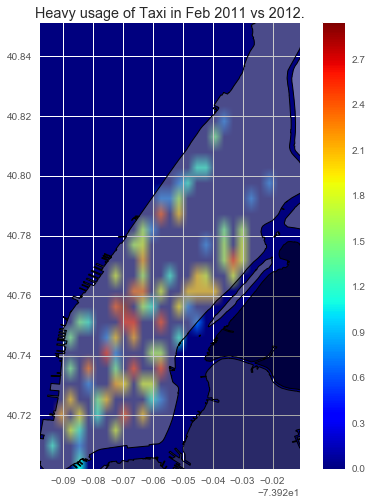

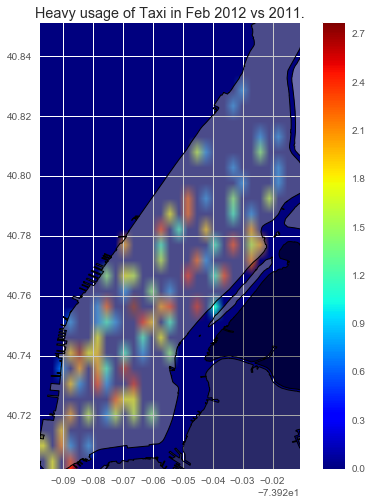

In [123]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
boros.plot(ax=ax)
plt.title('Heavy usage of Taxi in Feb 2011 vs 2012.')
h_net,norm = draw_diff(taxi_before,taxi_after,30,cmap='jet')
print "The decrease in trips in bins where the taxi usage decreased: ", norm

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
boros.plot(ax=ax)
plt.title('Heavy usage of Taxi in Feb 2012 vs 2011.')
h_net,norm = draw_diff(taxi_after,taxi_before,30,cmap='jet')
print "The increase in trips in bins where the taxi usage increased: ", norm

The above heat-maps show particular areas where usage patterns have changed significantly for taxis. The value of norms of these differences indicate that more areas have lost demand compared to the ones that have improved over one year. This remains valid for larger sample sizes as well.

Moreover, the heat-map for heavy usage of taxis in 2011 v/s 2012 is similar to the one for Uber v/s Taxi. This means the launch of Uber is a probably cause for that decrease in taxis in such areas. Thus, our initial question about the impact of Uber on the Taxi business is resolved reasonably well.

# Questions that we can try to answer

1. Which foursquare venues are more popular than what can be seen from the density of check-ins themselves?
2. Which subway stations have the most people using taxis and ubers to continue their journey?
3. Are taxi/uber rides more frequent close to subways or far away from them?

## Temporal Analysis

We are also interested in seeing the differences between taxi and uber usage at different times of day

In [124]:
hour_dist = uber['Date/Time'][:10000].apply(pd.to_datetime).apply(lambda x: x.hour).value_counts()

In [125]:
print taxi.head()

   pickup_longitude  pickup_latitude                              geometry
0        -73.978165        40.757977          POINT (-73.978165 40.757977)
1        -74.006683        40.731781          POINT (-74.006683 40.731781)
2        -74.004707        40.737770           POINT (-74.004707 40.73777)
3        -73.974602        40.759945          POINT (-73.974602 40.759945)
4        -73.976250        40.748528  POINT (-73.97624999999999 40.748528)


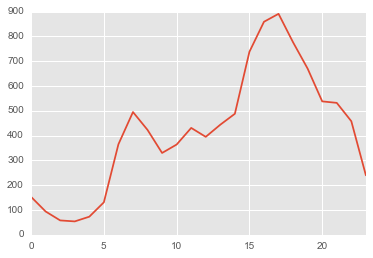

In [126]:
hour_dist = hour_dist.sort_index()
hour_dist.plot()

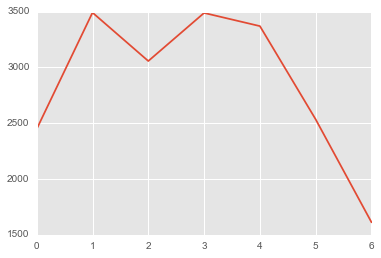

In [127]:
day_dist = uber['Date/Time'][:20000].apply(pd.to_datetime).apply(lambda x: x.weekday()).value_counts()
day_dist = day_dist.sort_index()
day_dist.plot()

## Street Data

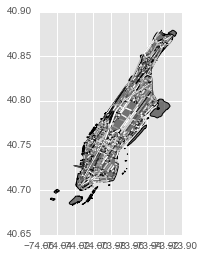

In [134]:
roads = gpd.GeoDataFrame.from_file('../new-york_new-york.imposm-shapefiles/new-york_new-york_osm_roads_gen0.shp').to_crs({'init': 'epsg:4326'})
roads1 = gpd.GeoDataFrame.from_file('../new-york_new-york.imposm-shapefiles/new-york_new-york_osm_roads_gen1.shp').to_crs({'init': 'epsg:4326'})
base = boros[boros['BoroName']=='Manhattan'].plot()
manhattan_roads = keep_manhattan(roads)
manhattan_roads1 = keep_manhattan(roads1)
manhattan_roads.plot(ax=base)
manhattan_roads1.plot(ax=base)

In [152]:
print manhattan_roads.apply(lambda x: x.geometry.length)#['name'].value_counts()[:50]

AttributeError: ("'Series' object has no attribute 'geometry'", u'occurred at index access')

## Time Prediction

In [151]:
manhattan_roads.iloc[0].geometry.length

0.0007214239592539598